## 2. Processing amplicon sequence data

This notebook will guide you through the process of cleaning 16S rRNA sequences (removing low quality reads and chimeras), performing taxonomic assignments, and removing contaminants that was used to process the sequences from this study in R using dada 2 (Callahan, 2016). You can find the R script in this same folder as dada2_processing.R.

### Loading packages and creating useful files

The first step is to set the directory where the sequences were downloaded as working directory:

In [ ]:
setwd(paste0("[your path]/data/raw/16S_rRNA_seqs"))

To confirm that the working directory is correct, we can run:

In [ ]:
getwd()

Follow the installation instructions for dada2: https://www.bioconductor.org/packages/release/bioc/html/dada2.html
After the installation, load the dada2 package:

In [31]:
library(dada2)
library(ggplot2)
library(reshape2)
library(dplyr)

First, we will create variables that will make running the following commands easier. The variable samples will contain all the sample IDs from the file unique-sample-IDs.txt:

In [19]:
samples <- scan("unique-sample-IDs.txt", what = "character")
head(samples) # to peek at it

[1] "DO-01_S234"  "DO-101_S223" "DO-102_S255" "DO-105_S217" "DO-107_S233"
[6] "DO-10_S245"

The variable forward reads will hold the paths to all the forward reads:

In [18]:
forward_reads <- paste0("primer-trimmed-reads/", samples, "-trimmed-R1.fastq.gz")
head(forward_reads) # to peek at it

[1] "primer-trimmed-reads/DO-01_S234-trimmed-R1.fastq.gz" 
[2] "primer-trimmed-reads/DO-101_S223-trimmed-R1.fastq.gz"
[3] "primer-trimmed-reads/DO-102_S255-trimmed-R1.fastq.gz"
[4] "primer-trimmed-reads/DO-105_S217-trimmed-R1.fastq.gz"
[5] "primer-trimmed-reads/DO-107_S233-trimmed-R1.fastq.gz"
[6] "primer-trimmed-reads/DO-10_S245-trimmed-R1.fastq.gz"

Similarly, the variable reverse reads will hold the paths for all the reverse reads:

In [25]:
reverse_reads <- paste0("primer-trimmed-reads/", samples, "-trimmed-R2.fastq.gz")
head(reverse_reads) # to peek at it

[1] "primer-trimmed-reads/DO-01_S234-trimmed-R2.fastq.gz" 
[2] "primer-trimmed-reads/DO-101_S223-trimmed-R2.fastq.gz"
[3] "primer-trimmed-reads/DO-102_S255-trimmed-R2.fastq.gz"
[4] "primer-trimmed-reads/DO-105_S217-trimmed-R2.fastq.gz"
[5] "primer-trimmed-reads/DO-107_S233-trimmed-R2.fastq.gz"
[6] "primer-trimmed-reads/DO-10_S245-trimmed-R2.fastq.gz"

Now we will create a directory to hold the output quality-filtered reads:

In [20]:
dir.create("quality-filtered-reads")

We will create empty variables that will be filled with the paths to the quality-filtered forward and reverse reads when we actually make those files:

In [21]:
filtered_forward_reads <- paste0("quality-filtered-reads/", samples, "-trimmed-filtered-R1.fastq.gz")
filtered_reverse_reads <- paste0("quality-filtered-reads/", samples, "-trimmed-filtered-R2.fastq.gz")

### Quality trimming/filtering

First, we will use the plotQualityProfile function to get a summary plot of the quality of the first sequence only:

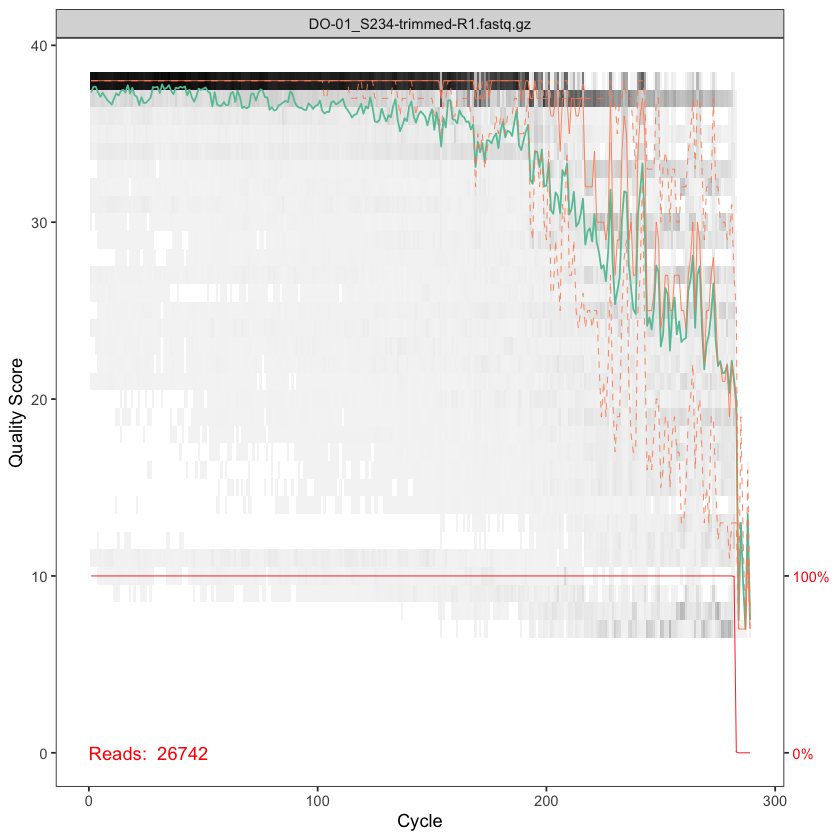

In [23]:
#Forward reads of first sample
plotQualityProfile(forward_reads[1])

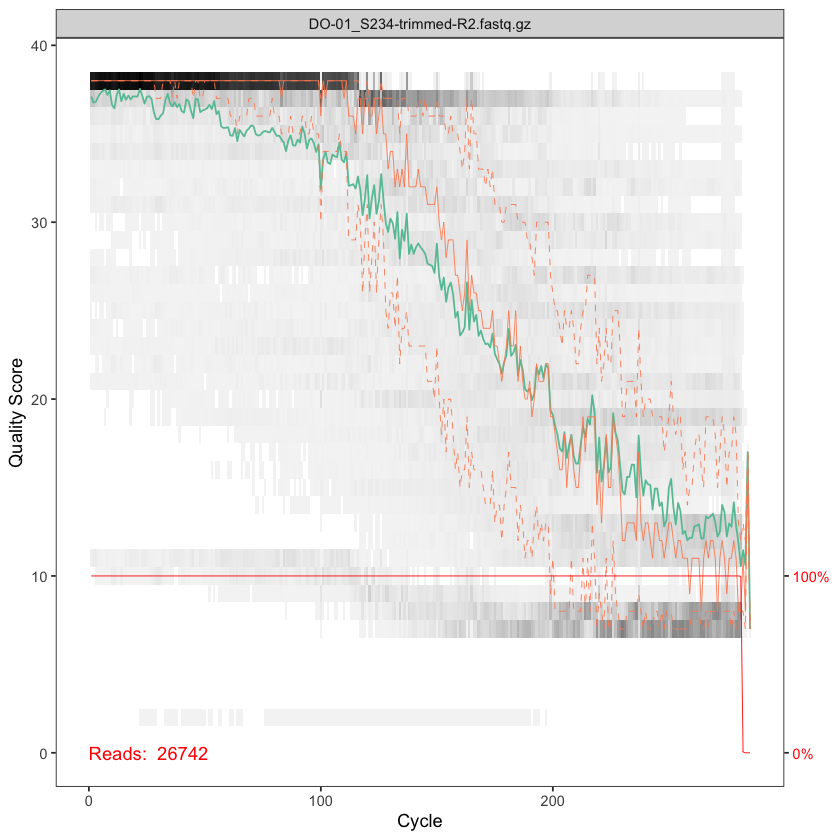

In [26]:
#Reverse reads of first sample
plotQualityProfile(reverse_reads[1])

#### Optional: Quantitative optimization of trim lengths

To figure out optimal trim lengths (choosing a quality threshold of 30 in this case), we will start by deefning a function to calculate statistics on the quality of the sequences:

In [141]:
#Define new function that reads through files in fastq format and utilizes a defined quality threshold (30 here)
get_stats_for_fastq <- function(raw_fastq, qthresh=30, n_subset=1e5) {
  #Create temporary dataframe with sequence scores based on quality
  quals <- ShortRead::qa(dirPath = raw_fastq, n=1e5)[['perCycle']]$quality
  #Overwrite the dataframe to include statistics for the scores of each sequence
  quals <- quals %>% 
    reframe(long_score = rep(Score, Count), .by=c(lane, Cycle)) %>% 
    reframe(mean_score = mean(long_score), sd_score=sd(long_score), med_score = median(long_score),
              mad_score=stats::mad(long_score, constant = 1), .by=c(lane, Cycle))%>% 
    rename(ID = lane)

  #Populate the 'quality' column with 'good quality'
  quals$quality <- 'good_quality'
  #If the mean score of the sequence is below the quality threshold, reassing the category in the 
  #quality column as 'bad quality'
  quals$quality[quals$mean_score < qthresh] <- 'bad_quality'
  #Reorganize ID column
  quals$ID <- factor(quals$ID, levels = unique(c(grep("-R1", quals$ID, value=T), grep("-R2", quals$ID, value=T))))

  
  return(quals)
}

We will define an additional function to calculate the position at which the sequence quality starts to markedly decrease based on where the 1st derivative for the mean score vs. cycle starts to decrease rapidly.

In [ ]:
diving_deriv <- function(df, thresh=-0.06) {
  x <- predict(loess(mean_score~Cycle, df))  # loess smooth out the jitters
  y <- df$Cycle
  
  fderiv <- diff(x) / diff(y)
  
  possibles <- which(fderiv < thresh)
  
  return(min(possibles))
}

Now that he have defined the functions, we will apply the quality statistics function to our dataset:

In [156]:
#Define a quality threshold for the get_stats_for_fastq function
quality_thresh <- 30

#Generate a dataframe with statistics for the scores of our sequences
#(for the first 3 sequences only)
stats_quality <- get_stats_for_fastq(c(forward_reads[1:3], reverse_reads[1:3]), qthresh = quality_thresh)
head(stats_quality)

ID                             Cycle mean_score sd_score med_score mad_score
1 DO-01_S234-trimmed-R1.fastq.gz 1     37.33079   2.848570 38        0        
2 DO-01_S234-trimmed-R1.fastq.gz 2     37.65799   1.738397 38        0        
3 DO-01_S234-trimmed-R1.fastq.gz 3     37.66177   1.857833 38        0        
4 DO-01_S234-trimmed-R1.fastq.gz 4     37.33460   2.786670 38        0        
5 DO-01_S234-trimmed-R1.fastq.gz 5     37.09203   3.437065 38        0        
6 DO-01_S234-trimmed-R1.fastq.gz 6     37.32234   2.766450 38        0        
  quality     
1 good_quality
2 good_quality
3 good_quality
4 good_quality
5 good_quality
6 good_quality

We will create variables to store the positions for each sequence where the quality starts to dip (first_bad), the last position with bad quality (last_bad), the middle between the  first and the last (middle), and an estimated position where the quality starts to markedly decline based on where the 1st derivative starts to decrease quickly.

In [147]:
first_bad <- sapply(levels(stats_quality$ID), function(x) 
  min(stats_quality$Cycle[stats_quality$quality == 'bad_quality' & (stats_quality$ID == x)]))
last_good <- sapply(levels(stats_quality$ID), function(x) 
  max(stats_quality$Cycle[stats_quality$quality == 'good_quality' & (stats_quality$ID == x)]))
middle <- first_bad + floor((last_good - first_bad)/2)
estimated <- sapply(levels(stats_quality$ID), 
    function(x) diving_deriv(stats_quality[stats_quality$ID == x,], thresh = -0.06))

Finally, we will create a dataframe to summarize the results:

In [150]:
summary_df <- data.frame(ID=names(estimated), first_bad=first_bad, middle=middle, last_good=last_good, estimated=estimated)
print(summary_df, row.names = F)

                              ID first_bad middle last_good estimated
  DO-01_S234-trimmed-R1.fastq.gz       213    227       242       172
 DO-101_S223-trimmed-R1.fastq.gz       139    151       163        75
 DO-102_S255-trimmed-R1.fastq.gz        96     95        95        37
  DO-01_S234-trimmed-R2.fastq.gz       128    132       137        75
 DO-101_S223-trimmed-R2.fastq.gz       116    121       127        63
 DO-102_S255-trimmed-R2.fastq.gz        98     97        97        35


We will now get a visual assessment of the quality of the first 3 sequences. In the following plot, the blue dots correspond to the cycles where the quality scores are above the threshold of 30, the red dots the cycles where the quality scores are below that threshold, and the shaded region corresponds to 1 standard deviation. The positions of the first bad cycle, the last one, and the middle of the two are marked with vertical teal, red, and gray lines, respectively.

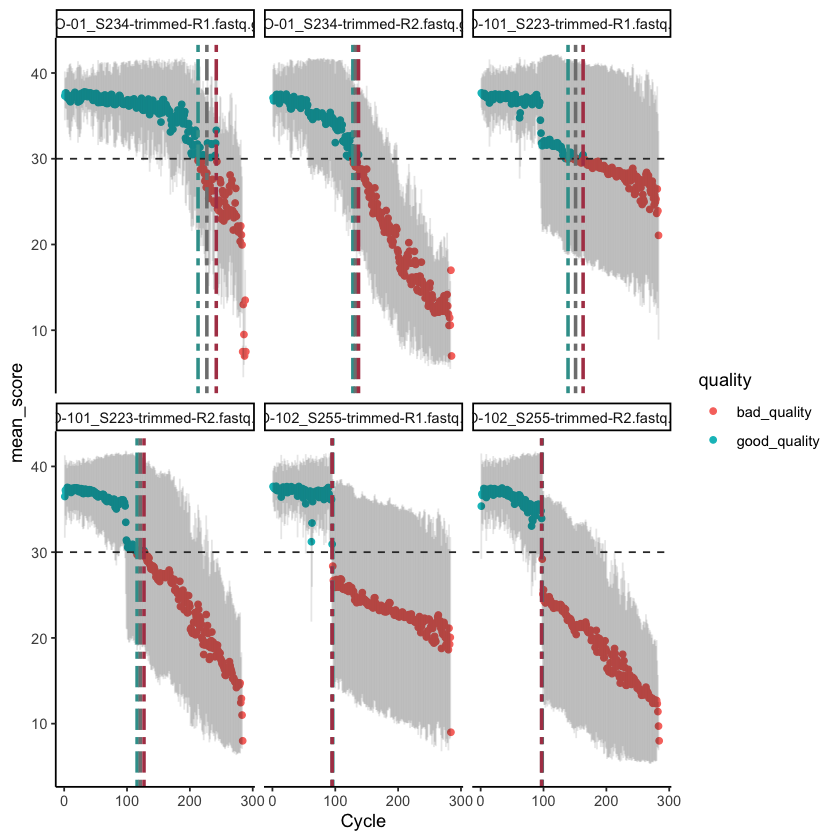

In [208]:
ggplot(stats_quality, aes(x=Cycle, y= mean_score)) + 
  geom_point(aes(color=quality)) +
  geom_linerange(aes(ymin=mean_score - sd_score, ymax=mean_score + sd_score), 
                 alpha=0.1, na.rm=TRUE) + 
  facet_wrap(~ID, ncol=3) +
  geom_hline(yintercept = 30, color='grey20', lty=2) +
  geom_vline(data=summary_df, aes(xintercept=first_bad), color='#399E9A', lty=6, linewidth=1) +
  geom_vline(data=summary_df, aes(xintercept=middle), color='grey50', lty=6, linewidth=1) +
  geom_vline(data=summary_df, aes(xintercept=last_good), color='#B04155', lty=6, linewidth=1) +
  #geom_vline(data=summary_df, aes(xintercept=estimated), color='cyan', lty=3) +
  theme_classic()

#### Skipping the optional optimization

Now we can apply the trimming on the sequences based on the quality plots or the optimization step. The plots from the previous step show us that the quality of the forward reads is variable, going down between ~150-250. However, there seems to be a systematic problem with the reverse sequences, where the quality dramatically decreases after 100 cycles. 
- The upper limit for trimming for 16S (411 bp) is of 170 (to have at least 12 bp of overlap in this case between the forward and reverse sequences), so we will choose to trim the forward sequences back to 240 and the reverse sequences back to 200, so that we still have 240+200-411=29 bases of overlap to work with. 
- We will set up a a maximum number of expected errors within the parameter maxEE,which will be 2 for both the forward and reverse reads. This implies that reads will be dropped if there is an expected possibility of having 2 wrong bases.
- To learn more about the parameters of the FilterAndTrim function, visit: https://rdrr.io/bioc/dada2/man/filterAndTrim.html

In [223]:
filtered_out <- filterAndTrim(forward_reads, filtered_forward_reads,
                              reverse_reads, filtered_reverse_reads, maxEE=c(2,2),
                              rm.phix=TRUE, truncLen=c(240,200))

In [225]:
# This command allows to transform the created matrix to a dataframe
filtered_out c(filtered_out)
# Now we will add a column to see what % of reads were kept
filtered_out$Percentage_reads_kept <- filtered_out[, 2] / filtered_out[, 1] * 100
head(filtered_out)

reads.in reads.out Percentage_reads_kept
DO-01_S234-trimmed-R1.fastq.gz  26742    13943     52.13896             
DO-101_S223-trimmed-R1.fastq.gz  7332     4340     59.19258             
DO-102_S255-trimmed-R1.fastq.gz  7053     2405     34.09896             
DO-105_S217-trimmed-R1.fastq.gz 11812     6333     53.61497             
DO-107_S233-trimmed-R1.fastq.gz 27805    13087     47.06707             
DO-10_S245-trimmed-R1.fastq.gz   9843     2598     26.39439

We can now take a look at the profiles of the quality-filtered sequences:

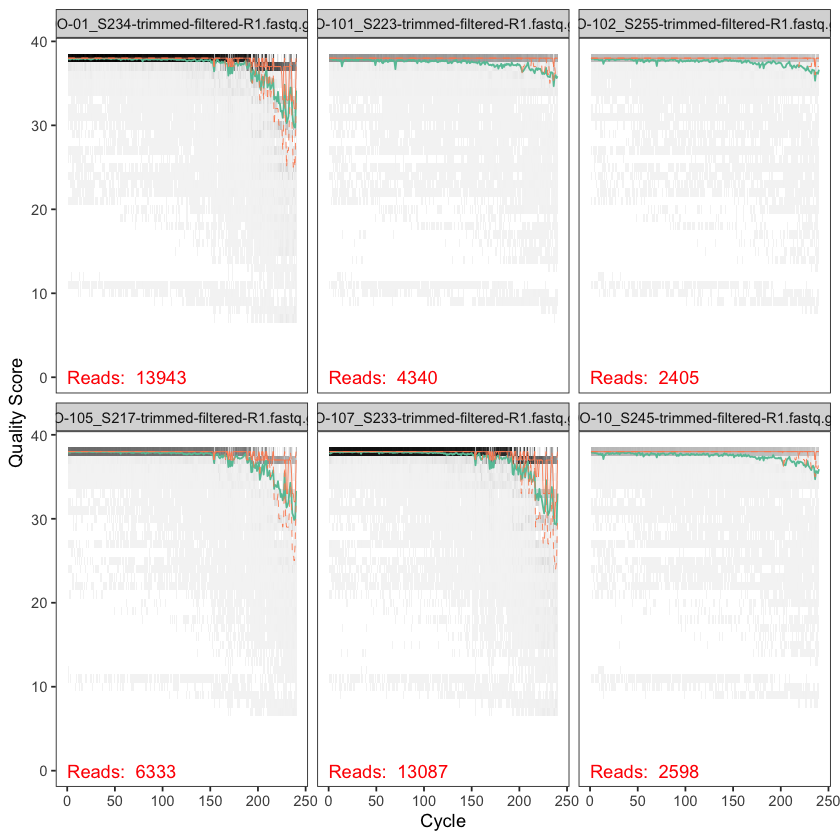

In [230]:
#For forward samples
plotQualityProfile(filtered_forward_reads[1:6])

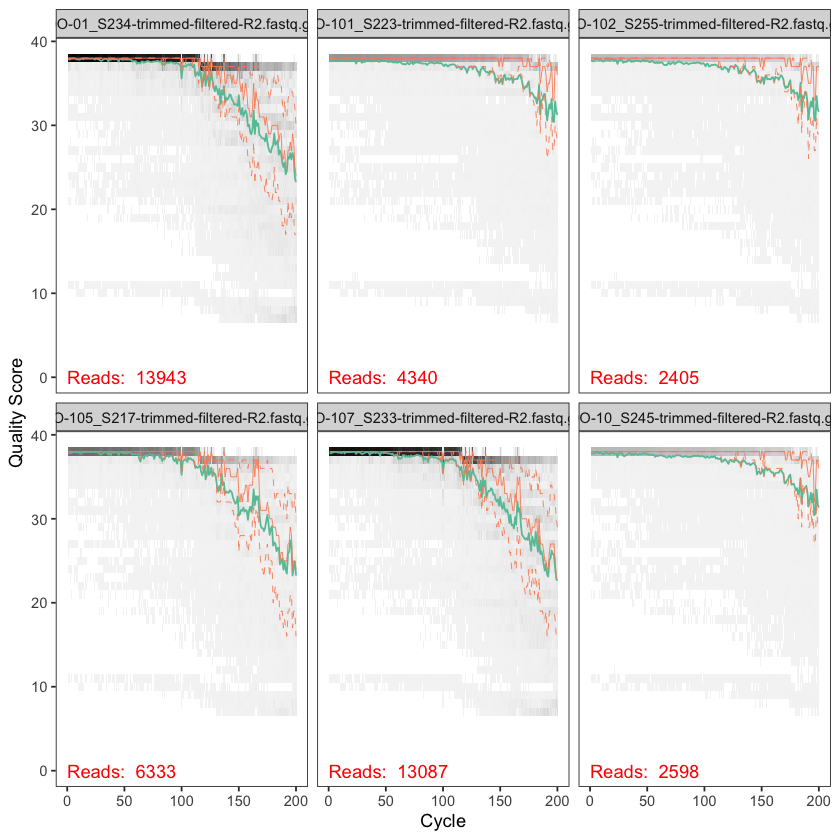

In [231]:
#For reverse samples
plotQualityProfile(filtered_reverse_reads[1:6])

### Generating an error model of the data

We will utilize the learnErrors function to perform an inference of the error rates for this particular dataset.

In [233]:
#Specific-error signature of the forward reads
err_forward_reads <- learnErrors(filtered_forward_reads, multithread = 4)
#Specific-error signature of the reverse reads
err_reverse_reads <- learnErrors(filtered_reverse_reads, multithread = 4)

100084080 total bases in 417017 reads from 43 samples will be used for learning the error rates.
100541600 total bases in 502708 reads from 52 samples will be used for learning the error rates.


We can optionally visualize the matching between the expected and observed error rates.

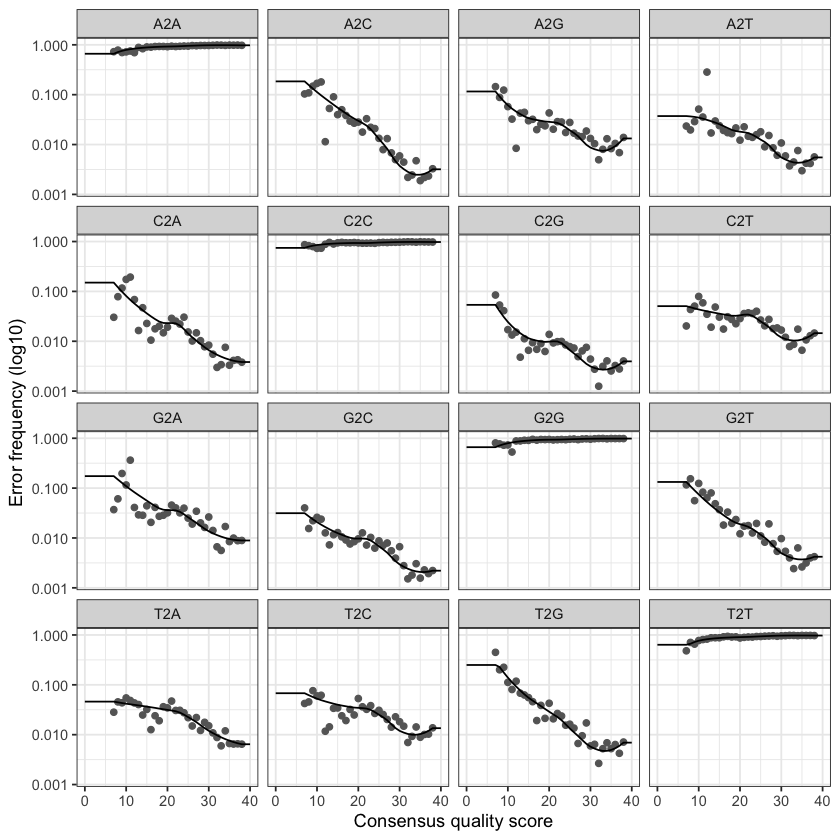

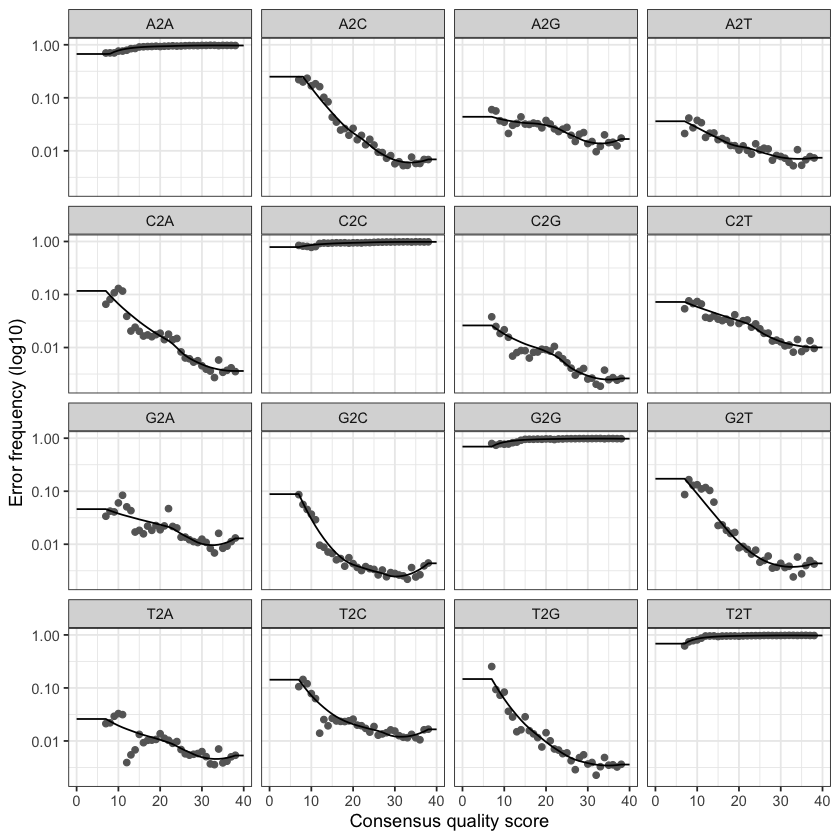

In [237]:
# Plot to visualize how the error rates match with the observed
plotErrors(err_forward_reads[1:9])
# Plot to visualize how the error rates match with the observed
plotErrors(err_reverse_reads[1:9])

Now, we will perform a dereplication step, which is intended to find unique sequences and assign them a new quality score based on the average score of all the replicates.

In [253]:
#Dereplicate sequences to find unique sequences
#For forward reads
derep_forward <- derepFastq(filtered_forward_reads, verbose=FALSE)
#For reverse reads
derep_reverse <- derepFastq(filtered_reverse_reads, verbose=FALSE)

In [255]:
#The sample names in these objects are initially the file names, this sets them to the sample names
#For forward reads
names(derep_forward) <- gsub("^.*/","", gsub("-trimmed.*$", "", filtered_forward_reads)) 
#For reverse reads
names(derep_reverse) <- gsub("^.*/","",gsub("-trimmed.*$", "", filtered_forward_reads))
head(derep_forward)

$`DO-01_S234`
derep-class: R object describing dereplicated sequencing reads
$uniques: 13943 reads in 3139 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  3139 240
  Consensus quality scores: min=7, median=38, max=38
$map: Map from reads to unique sequences:  1650 47 27 2803 38 ...

$`DO-101_S223`
derep-class: R object describing dereplicated sequencing reads
$uniques: 4340 reads in 2358 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  2358 240
  Consensus quality scores: min=8, median=38, max=38
$map: Map from reads to unique sequences:  599 20 269 269 4 ...

$`DO-102_S255`
derep-class: R object describing dereplicated sequencing reads
$uniques: 2405 reads in 1316 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  1316 240
  Consensus quality scores: min=8, median=38, max=38
$map: Map from reads to unique sequences:  279 1 1 1260 1 ...

$`DO-105_S217`
derep-class: R object describing dereplicated sequencing reads
$uniques: 6333 reads in 1804 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  1804 240
  Consensus quality scores: min=7, median=38, max=38
$map: Map from reads to unique sequences:  180 2 18 1 3 ...

$`DO-107_S233`
derep-class: R object describing dereplicated sequencing reads
$uniques: 13087 reads in 2900 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  2900 240
  Consensus quality scores: min=7, median=38, max=38
$map: Map from reads to unique sequences:  2 7 1478 60 40 ...

$`DO-10_S245`
derep-class: R object describing dereplicated sequencing reads
$uniques: 2598 reads in 1417 unique sequences
  Sequence lengths: min=240, median=240, max=240
$quals: Quality matrix dimension:  1417 240
  Consensus quality scores: min=8, median=38, max=38
$map: Map from reads to unique sequences:  19 1087 14 28 472 ...

Now we will use the denoising algorithm to correct the amplicon errors based on the generated error models.

In [256]:
#Denoising of the forward filtered reads
dada_forward <- dada(derep_forward, err=err_forward_reads, pool="pseudo", multithread=4)
#Denoising of the reverse filtered reads
dada_reverse <- dada(derep_reverse, err=err_reverse_reads, pool="pseudo", multithread=4)

Sample 1 - 13943 reads in 3139 unique sequences.
Sample 2 - 4340 reads in 2358 unique sequences.
Sample 3 - 2405 reads in 1316 unique sequences.
Sample 4 - 6333 reads in 1804 unique sequences.
Sample 5 - 13087 reads in 2900 unique sequences.
Sample 6 - 2598 reads in 1417 unique sequences.
Sample 7 - 4583 reads in 2201 unique sequences.
Sample 8 - 5045 reads in 2219 unique sequences.
Sample 9 - 4359 reads in 2090 unique sequences.
Sample 10 - 4960 reads in 2048 unique sequences.
Sample 11 - 10658 reads in 4054 unique sequences.
Sample 12 - 2864 reads in 1568 unique sequences.
Sample 13 - 7601 reads in 3405 unique sequences.
Sample 14 - 3526 reads in 2334 unique sequences.
Sample 15 - 14413 reads in 6852 unique sequences.
Sample 16 - 13391 reads in 2632 unique sequences.
Sample 17 - 7059 reads in 1757 unique sequences.
Sample 18 - 6057 reads in 3111 unique sequences.
Sample 19 - 4586 reads in 978 unique sequences.
Sample 20 - 8519 reads in 3353 unique sequences.
Sample 21 - 2275 reads in

### Amplicon merge

Now, we are ready to merge the denoised forward and reverse reads. Below, the trimOverhang parameter removes overlap if the reverse read goes past the start of the forward one or viceversa.We will establish a minimum overlap of 12 base pairs.

In [257]:
merged_amplicons <- mergePairs(dada_forward, 
                               derep_forward, 
                               dada_reverse,
                               derep_reverse,
                               trimOverhang=TRUE,
                               minOverlap=12)

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.



In [258]:
#Generate a count table
seqtab <- makeSequenceTable(merged_amplicons)
# See number of unique sequences across our dataset
dim(seqtab) 

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



[1]    96 18478

We will visualize now the fraction of merged sequences for each sample.

In [265]:
#Create dataframe
merged_fraction <- as.data.frame(rowSums(seqtab) / rowSums(makeSequenceTable(dada_forward)))
#Rename column
names(merged_fraction)[names(merged_fraction) == 'rowSums(seqtab)/rowSums(makeSequenceTable(dada_forward))'] <- 
"Merged fraction"
merged_fraction

Merged fraction
DO-01_S234       0.8288530      
DO-101_S223      0.7203240      
DO-102_S255      0.7460391      
DO-105_S217      0.8596235      
DO-107_S233      0.8584160      
DO-10_S245       0.7051071      
DO-110_S207      0.7585421      
DO-113_S242      0.7656346      
DO-114_S208      0.6798916      
DO-115_S209      0.8108781      
DO-116_S206      0.8044085      
DO-11_S254       0.6341748      
DO-12_S204       0.7292643      
DO-13_S253       0.4967253      
DO-14_S213       0.6210120      
DO-152_S231      0.8969440      
DO-152-star_S236 0.8592177      
DO-153_S233      0.7172401      
DO-154_S211      0.9016538      
DO-154_S218      0.8366849      
DO-156_S235      0.7504699      
DO-157_S216      0.8501493      
DO-158_S230      0.8779282      
DO-159_S221      0.7998146      
DO-15_S214       0.6012330      
DO-15_S251       0.6381487      
DO-161_S243      0.7739261      
DO-162_S219      0.6987403      
DO-16_S215       0.6382263      
DO-17_S203       0.7929809      
...              ...            
DO-63_S231       0.8491903      
DO-68_S219       0.9047518      
DO-69_S226       0.7415945      
DO-6_S250        0.8394460      
DO-70_S210       0.5218949      
DO-71_S220       0.8843296      
DO-72_S211       0.6876763      
DO-73_S199       0.7899931      
DO-74_S217       0.8048297      
DO-77_S220       0.8001559      
DO-78_S208       0.8483450      
DO-79_S228       0.7947657      
DO-7_S222        0.7943131      
DO-81_S227       0.7352406      
DO-83_S248       0.7310103      
DO-84_S221       0.5742773      
DO-85_S225       0.8434703      
DO-86_S216       0.8133464      
DO-87_S224       0.7219754      
DO-88_S212       0.7988966      
DO-8_S247        0.7928894      
DO-93_S223       0.7215399      
DO-98_S210       0.9126101      
DO-98_S215       0.8052818      
DO-99_S240       0.7925703      
DO-a_S214        0.7156154      
DO-ne-35_S212    0.9245630      
DO-ne-45_S206    0.8989647      
DO-np-35_S222    0.9276492      
DO-np-45_S207    0.9492958

 ### Chimera cleaning

In [266]:
#The following command will remove the chimeras out of the sequences
seqtab.nochim <- removeBimeraDenovo(seqtab, verbose = TRUE, method = 'consensus')

Identified 11612 bimeras out of 18478 input sequences.



Although we retained 57-95% of our unique sequences, we don’t know if those particular sequences held a lot in terms of abundance yet. Here is one quick way we can look at that:

In [269]:
abundance_fr_read_retained <- sum(seqtab.nochim) / sum(seqtab)
round(abundance_fr_read_retained,2)

[1] 0.75

This implies that in terms of abundance, we are retaining about 75% of reads following chimeral removal.


We will generate a summary of the read retention by step. First, we will make a helper function and then we will create the summary table.

In [278]:
#Assign function to get unique sequences to variable
getN <- function(x) sum(getUniques(x))
# Make the summary table
summary_tab <- data.frame(row.names = samples,
                          samp=samples,
                          dada2_input = filtered_out[,1],
                          filtered = filtered_out[,2],
                          dada_f = sapply(dada_forward, getN),
                          dada_r = sapply(dada_reverse, getN), 
                          merged = sapply(merged_amplicons, getN),
                          nonchim = rowSums(seqtab.nochim),
                          final_perc_reads_retained=round(rowSums(seqtab.nochim)/filtered_out[,1]*100, 1))


#See the summary table                                               
summary_tab

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



samp             dada2_input filtered dada_f dada_r merged
DO-01_S234       DO-01_S234       26742       13943    13801  13752  11439 
DO-101_S223      DO-101_S223       7332        4340     3951   3953   2846 
DO-102_S255      DO-102_S255       7053        2405     2146   2176   1601 
DO-105_S217      DO-105_S217      11812        6333     6162   6178   5297 
DO-107_S233      DO-107_S233      27805       13087    12904  12820  11077 
DO-10_S245       DO-10_S245        9843        2598     2428   2434   1712 
DO-110_S207      DO-110_S207       7687        4583     4390   4424   3330 
DO-113_S242      DO-113_S242       5685        5045     4877   4792   3734 
DO-114_S208      DO-114_S208       9206        4359     4058   4140   2759 
DO-115_S209      DO-115_S209       9268        4960     4817   4833   3906 
DO-116_S206      DO-116_S206      21205       10658    10389  10395   8357 
DO-11_S254       DO-11_S254        6155        2864     2575   2604   1633 
DO-12_S204       DO-12_S204       11725        7601     7258   7204   5293 
DO-13_S253       DO-13_S253        4162        3526     2901   2981   1441 
DO-14_S213       DO-14_S213       26536       14413    12945  13270   8039 
DO-152_S231      DO-152_S231      25838       13391    13187  13239  11828 
DO-152-star_S236 DO-152-star_S236 14966        7059     6954   6900   5975 
DO-153_S233      DO-153_S233       8167        6057     5609   5606   4023 
DO-154_S211      DO-154_S211      11200        4586     4535   4515   4089 
DO-154_S218      DO-154_S218      17878        8519     8205   8225   6865 
DO-156_S235      DO-156_S235       4287        2275     2128   2136   1597 
DO-157_S216      DO-157_S216      19917        3453     3350   3365   2848 
DO-158_S230      DO-158_S230      29747       15739    15581  15548  13679 
DO-159_S221      DO-159_S221       9465        5605     5395   5377   4315 
DO-15_S214       DO-15_S214       28574       15757    14274  14590   8582 
DO-15_S251       DO-15_S251        3521        3057     2852   2814   1820 
DO-161_S243      DO-161_S243      10944        2774     2654   2659   2054 
DO-162_S219      DO-162_S219      13551        8062     7462   7515   5214 
DO-16_S215       DO-16_S215       35145       17490    16057  16394  10248 
DO-17_S203       DO-17_S203       11120        9735     9289   9412   7366 
...              ...              ...         ...      ...    ...    ...   
DO-63_S231       DO-63_S231       13985        8199     7904   7942   6712 
DO-68_S219       DO-68_S219       11647        4816     4735   4756   4284 
DO-69_S226       DO-69_S226       22820       13467    13057  13103   9683 
DO-6_S250        DO-6_S250         8967        4000     3899   3904   3273 
DO-70_S210       DO-70_S210       10655        5849     5024   5132   2622 
DO-71_S220       DO-71_S220       29492       15629    15475  15485  13685 
DO-72_S211       DO-72_S211        9855        8663     8155   8079   5608 
DO-73_S199       DO-73_S199       24826       16400    15909  16061  12568 
DO-74_S217       DO-74_S217       10110        5799     5549   5526   4466 
DO-77_S220       DO-77_S220       12294        9329     8982   9048   7187 
DO-78_S208       DO-78_S208       12451        6354     6284   6262   5331 
DO-79_S228       DO-79_S228       21929       12825    12571  12599   9991 
DO-7_S222        DO-7_S222        23799       14087    13540  13527  10755 
DO-81_S227       DO-81_S227       13170        6534     6047   6146   4446 
DO-83_S248       DO-83_S248       15926       14107    13402  13605   9797 
DO-84_S221       DO-84_S221       26074       14911    13941  14147   8006 
DO-85_S225       DO-85_S225       40774       20981    20667  20658  17432 
DO-86_S216       DO-86_S216       11896        6367     6129   6106   4985 
DO-87_S224       DO-87_S224       21078       12119    11704  11775   8450 
DO-88_S212       DO-88_S212       14301        5879     5619   5625   4489 
DO-8_S247        DO-8_S247         8761        3681     3544   35

We will now make a box and jitter plot to visualize the reads throughout the process:

Using samp as id variables



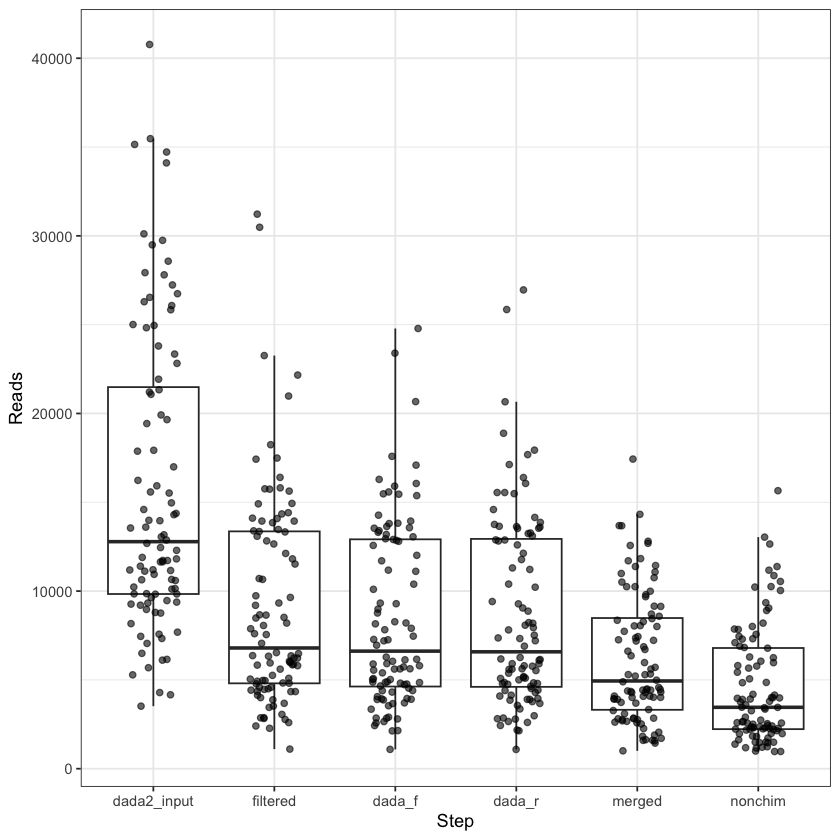

In [282]:
#We will first use melt to reshape the table above into a long format
long_table_reads <- melt(summary_tab[,-ncol(summary_tab)], variable.name='Step', value.name='Reads')
#Now we will make the box and jitter plot
ggplot(long_table_reads, aes(x = Step, y = Reads)) +
  geom_boxplot(outlier.shape = NA) + theme_bw() +
  geom_jitter(height=0, width=0.2, color='black', alpha=0.6)

We will generate an additional plot that will show us the fraction of reads in each step that below to samples vs. controls of DNA extraction and PCR.

Using samp as id variables



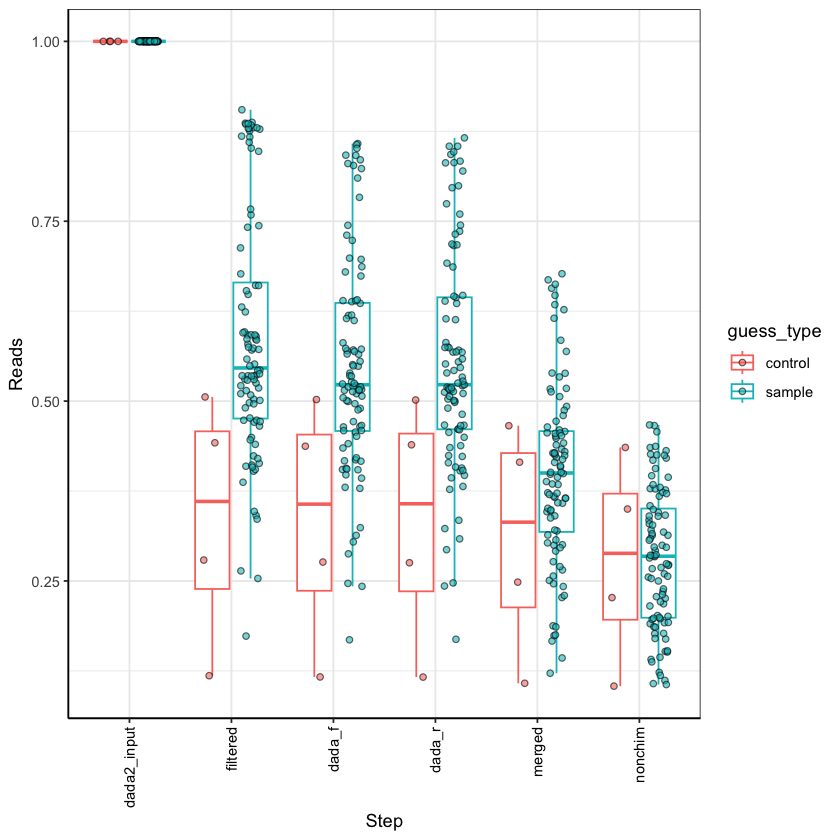

In [283]:
melt(summary_tab[,-ncol(summary_tab)], variable.name='Step', value.name='Reads') %>% group_by(samp) %>%
  mutate(Reads=Reads/Reads[Step == "dada2_input"]) %>% mutate(guess_type='sample') %>% 
  mutate(guess_type=replace(guess_type, grep("ne|np",samp), 'control')) %>%
  ggplot(aes(x = Step, y = Reads)) +
  geom_boxplot(aes(color = guess_type), outlier.shape = NA) + theme_bw() +
  geom_point(position=position_jitterdodge(jitter.height=0, jitter.width=0.2), aes(fill=guess_type), alpha=0.6, pch=21) +
	theme(axis.text.x = element_text(angle = 90, color='black', hjust=1, vjust=0.5), panel.background = element_blank(),
	      axis.line.x = element_line(), axis.line.y = element_line())

 ### Assigning taxonomy

You will start by dowloading the SILVA v138 reference database that your sequences will be compared to. 
This will take about 30 minutes to run on a standard laptop.

In [ ]:
# Downloading DECIPHER-formatted SILVA v138 reference
# download.file(url="http://www2.decipher.codes/Classification/TrainingSets/SILVA_SSU_r138_2019.RData", destfile="SILVA_SSU_r138_2019.RData")

# Loading reference taxonomy object
# load("SILVA_SSU_r138_2019.RData")

# Now you will install and load the DECIPHER package
library(DECIPHER)

Now, we will extract the sequences from the table cleaned of chimeras, create a DNAStringSet object, and classify it using both strands. By default, it will utilize a threshold of 60% condifence for the taxonomic assignments of the ASVs.

In [291]:
# Creating DNAStringSet object of our ASVs
dna <- DNAStringSet(getSequences(seqtab.nochim))

In [ ]:
# And taxonomically classifying the ASVs
tax_info <- IdTaxa(test = dna, 
                   trainingSet = trainingSet, 
                   strand = "both", 
                   processors = 4)

We will save the data as a fasta of ASV representative sequences, so that we can access it to make plots later.

In [ ]:
# Here we will give our sequence headers more manageable names (ASV_1, ASV_2...)
asv_seqs <- colnames(seqtab.nochim)
#This will make an empty vector that is going to hold the new names
asv_headers <- vector(dim(seqtab.nochim)[2], mode = "character")
#Now, we will assign the new headers to the sequences
for (i in 1:dim(seqtab.nochim)[2]) {
  asv_headers[i] <- paste(">ASV", i, sep = "_")
}
#Finally, we can make and write out a fasta of the final ASV seqs:
asv_fasta <- c(rbind(asv_headers, asv_seqs))
write(asv_fasta, "ASVs.fa")

Similarly, we will create a count table to export.

In [ ]:
# Create count table:
asv_tab <- t(seqtab.nochim)
colnames(asv_tab) <- samples
#Find the > symbol and replace it with nothing in asv_headers and assign them to row.names
row.names(asv_tab) <- sub(">", "", asv_headers)
#Create external table file
write.table(asv_tab, "ASVs_counts.tsv", sep="\t", quote=F, col.names=NA)

### Creating taxonomy table

 We will create a taxonomy table based on our ASVs and set any sequences that are unclassified as "NA".


In [ ]:
#Define taxonomic categories
ranks <- c("domain", "phylum", "class", "order", "family", "genus", "species")
#Make taxonomy table
asv_tax <- t(sapply(tax_info, function(x) {
  m <- match(ranks, x$rank)
  taxa <- x$taxon[m]
  taxa[startsWith(taxa, "unclassified_")] <- NA
  taxa
}))

#Set taxonomic categories as column names
colnames(asv_tax) <- ranks
rownames(asv_tax) <- gsub(pattern = ">", replacement = "", x = asv_headers)

#Export table
write.table(asv_tax, "ASVs_taxonomy.tsv", sep = "\t", quote=F, col.names=NA)

We are now ready to analyze the amplicon sequence data.